In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

%matplotlib inline

In [2]:
engagement_df = pd.read_csv('takehome_user_engagement.csv')
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [3]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [4]:
users_df = pd.read_csv('takehome_users.csv')
users_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [5]:
users_df.rename(columns={'object_id': 'user_id'}, inplace=True)

### Some Data Cleaning & A New Metric

In the end we have to create a  value that is "an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven­day  period"

In [6]:
# The easy part is getting a list of everyone that has logged in at least 3X
engagement_counts = engagement_df["user_id"].value_counts()
engaged_3x = pd.DataFrame(engagement_counts[engagement_counts >= 3]).reset_index()

In [7]:
engaged_3x.tail()
#Now how many of them at within a 7day timeframe...? Tricky.

,index,user_id
2243,6090,3
2244,8464,3
2245,5528,3
2246,6900,3
2247,7310,3


In [8]:
engaged_3x.rename(columns={'user_id': 'login_counts','index': 'user_id' }, inplace=True)

In [9]:
# start with time_stamp to dt
engagement_df['time_stamp'] = pd.to_datetime(engagement_df['time_stamp'])

In [10]:
engagement_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [11]:
#lets set a time delta for logic
seven_days = datetime.timedelta(7)

In [12]:
for user_id in engaged_3x.user_id:
    
    #get me all of the user logins for a unique User ID
    uts = engagement_df[engagement_df['user_id'] == 2]
    uts = uts.sort_values('time_stamp')
    uts['time_stamp_3'] = uts['time_stamp'].shift(-2)

In [13]:
uts

,time_stamp,user_id,visited,time_stamp_3
1,2013-11-15 03:45:04,2,1,2013-12-09 03:45:04
2,2013-11-29 03:45:04,2,1,2013-12-25 03:45:04
3,2013-12-09 03:45:04,2,1,2013-12-31 03:45:04
4,2013-12-25 03:45:04,2,1,2014-01-08 03:45:04
5,2013-12-31 03:45:04,2,1,2014-02-03 03:45:04
6,2014-01-08 03:45:04,2,1,2014-02-08 03:45:04
7,2014-02-03 03:45:04,2,1,2014-02-09 03:45:04
8,2014-02-08 03:45:04,2,1,2014-02-13 03:45:04
9,2014-02-09 03:45:04,2,1,2014-02-16 03:45:04
10,2014-02-13 03:45:04,2,1,2014-03-09 03:45:04


In [14]:
(uts.time_stamp <= (uts.time_stamp_3 - seven_days)).any()

True

In [15]:
#Load an empty Dict
auser_dict = {}

"""
Some of this control logic comes from the internet, 
 I Googled an answer that helped me work out my own different solution, but without resetting to False.  
Credit - https://github.com/dpalbrecht/Relax-Data-Challenge/

"""

#for all the users the engaged at least 3X
for user_id in engaged_3x.user_id:
    #You have to Set something to start
    adopted_user = False
    #get me all of the user logins for Each Unique User ID
    uts = engagement_df[engagement_df['user_id'] == user_id]
    uts = uts.sort_values('time_stamp')
    uts['time_stamp_3'] = uts['time_stamp'].shift(-2)
    
    #now go through those rows
    for row in uts.iterrows():
        #If you are True, don't undo the logic and make them false if they go cold later, this was tripping me up. 
        if adopted_user == True:
            continue
        #Get the times
        time_one = uts.time_stamp
        time_three = uts.time_stamp_3
        #do the 7day logic 
        if (time_one >= (time_three - seven_days)).any():
            adopted_user = True
    #Set User Status
    auser_dict[user_id] = adopted_user

In [16]:
auser_dict

{8192: True,
 2: True,
 8196: True,
 8201: True,
 10: True,
 8206: True,
 20: True,
 8214: True,
 8217: True,
 8220: True,
 8221: True,
 33: True,
 8232: True,
 8233: True,
 42: True,
 8235: True,
 8239: True,
 50: True,
 8243: True,
 53: True,
 59: True,
 8252: True,
 8254: True,
 63: True,
 8258: True,
 8259: True,
 69: True,
 8265: True,
 74: True,
 8269: True,
 8270: True,
 80: True,
 81: True,
 82: True,
 9571: True,
 8277: True,
 8278: True,
 87: True,
 8280: True,
 8286: True,
 95: True,
 8294: True,
 8297: True,
 8302: True,
 8310: True,
 8311: True,
 8312: True,
 8314: True,
 126: True,
 8319: True,
 133: True,
 135: True,
 136: True,
 141: True,
 8334: True,
 8337: True,
 146: True,
 153: True,
 8348: True,
 160: True,
 165: True,
 168: True,
 171: True,
 172: True,
 8366: True,
 8367: True,
 8371: True,
 185: True,
 188: True,
 8381: True,
 8383: True,
 197: True,
 200: True,
 8393: True,
 202: True,
 203: True,
 8399: True,
 209: True,
 8403: True,
 214: True,
 8408: True,


In [17]:
auser_df = pd.DataFrame.from_dict(auser_dict, orient='index').reset_index()

In [18]:
auser_df.head()

,index,0
0,8192,True
1,2,True
2,8196,True
3,8201,True
4,10,True


In [19]:
auser_df.rename(columns={0: 'active','index': 'user_id' }, inplace=True)

In [20]:
auser_df.active.sum()

2248

In [21]:
df = users_df.merge(auser_df, how='left', on='user_id')
df = df.merge(engaged_3x, how='left', on='user_id') 
df.login_counts = df.login_counts.fillna(0)
df.active = df.active.fillna(False).astype('int')

In [22]:
df.head()

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active,login_counts
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1,14.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0,0.0


In [23]:
df.shape

(12000, 12)

In [24]:
adopted_user_percentage = len(df[df['active'] == True]) / len(df)
print('Adopted User Percentage: {0}'.format(adopted_user_percentage))

Adopted User Percentage: 0


In [25]:
df.creation_source.value_counts()

ORG_INVITE            4254
GUEST_INVITE          2163
PERSONAL_PROJECTS     2111
SIGNUP                2087
SIGNUP_GOOGLE_AUTH    1385
Name: creation_source, dtype: int64

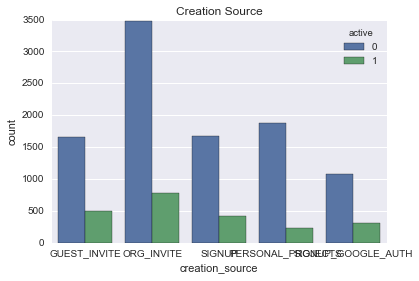

In [26]:
sns.countplot(x='creation_source', hue='active', data=df)
plt.title('Creation Source')
plt.show()

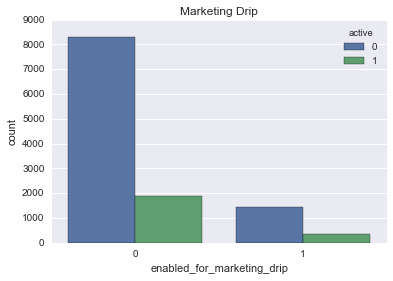

In [27]:
sns.countplot(x='enabled_for_marketing_drip', hue='active', data=df)
plt.title('Marketing Drip')
plt.show()

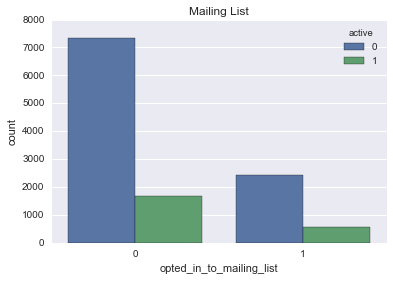

In [28]:
sns.countplot(x='opted_in_to_mailing_list', hue='active', data=df)
plt.title('Mailing List')
plt.show()

In [29]:
#gots to make some dummies
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 12 columns):
user_id                       12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
active                        12000 non-null int64
login_counts                  12000 non-null float64
dtypes: float64(3), int64(5), object(4)
memory usage: 1.2+ MB


In [30]:
df.invited_by_user_id = df.invited_by_user_id.fillna(0)
df = df.drop(['user_id','last_session_creation_time', 'name', 'email','creation_time','login_counts'], axis=1)

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 0 to 11999
Data columns (total 6 columns):
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            12000 non-null float64
active                        12000 non-null int64
dtypes: float64(1), int64(4), object(1)
memory usage: 656.2+ KB


In [32]:
df = pd.get_dummies(df)

In [33]:
df.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,active,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,11,10803.0,0,1.0,0.0,0.0,0.0,0.0
1,0,0,1,316.0,1,0.0,1.0,0.0,0.0,0.0
2,0,0,94,1525.0,0,0.0,1.0,0.0,0.0,0.0
3,0,0,1,5151.0,0,1.0,0.0,0.0,0.0,0.0
4,0,0,193,5240.0,0,1.0,0.0,0.0,0.0,0.0


In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

In [35]:
# Split data
y = np.array(df.active)
X = np.array(df.drop('active', axis=1))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [36]:
# Grid Search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
logc = GridSearchCV(LogisticRegression(penalty='l2'), param_grid)
logc.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [37]:
# View best hyperparameters
print('Best C:', logc.best_estimator_.get_params()['C'])

('Best C:', 0.001)


In [38]:
#Run the Logistic regression with the best C
log_model = LogisticRegression(C=0.001, class_weight='balanced')
log_model.fit(X_train, y_train)
y_pred=log_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Inactive', 'Active']))

             precision    recall  f1-score   support

   Inactive       0.86      0.47      0.61      3224
     Active       0.22      0.65      0.33       736

avg / total       0.74      0.51      0.56      3960



In [39]:
#ROC Score
fpr, tpr, thresholds = roc_curve(y_train, log_model.predict_proba(X_train)[:, 1])
auc = roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1])
print("AUC: {}".format(auc))

AUC: 0.588057933367


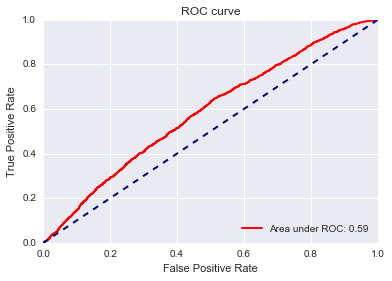

In [40]:
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='Area under ROC: {:.2f}'.format(auc))
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC curve')
plt.show()

In [41]:
# Present features importance by their corresponding coefficients in logistic regression
coef = list(zip(df.drop('active', axis=1).columns, log_model.coef_[0]))
log_fet  = pd.DataFrame(coef, columns=['feature', 'coefficient'])

log_fet.set_index('feature').sort_values('coefficient', ascending=False)

,coefficient
feature,
creation_source_GUEST_INVITE,0.041098
creation_source_SIGNUP_GOOGLE_AUTH,0.033233
creation_source_SIGNUP,0.023621
enabled_for_marketing_drip,0.011039
opted_in_to_mailing_list,0.007461
org_id,0.001096
invited_by_user_id,0.000005
creation_source_ORG_INVITE,-0.050931
creation_source_PERSONAL_PROJECTS,-0.152072


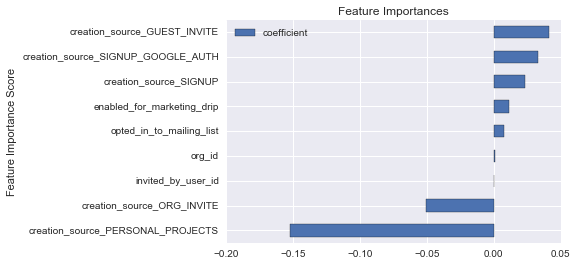

In [42]:
log_fet.set_index('feature').sort_values('coefficient').plot(kind='barh', title='Feature Importances')
plt.ylabel('Feature Importance Score')

In [43]:
# Use gridsearch for tuning parameters
gb = GradientBoostingClassifier()
parameters = {'learning_rate':[0.01, 0.1, 0.2, 0.3], 'n_estimators':[150, 200, 250, 300]}
gbc = GridSearchCV(gb, parameters, cv=5, scoring='accuracy')
gbc.fit(X_train, y_train)
gbc.best_params_

{'learning_rate': 0.01, 'n_estimators': 300}

In [44]:
gb = GradientBoostingClassifier(learning_rate=0.01, n_estimators=250)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['Inactive', 'Retained']))

             precision    recall  f1-score   support

   Inactive       0.81      1.00      0.90      3224
   Retained       0.00      0.00      0.00       736

avg / total       0.66      0.81      0.73      3960



In [45]:
#ROC Score
fpr, tpr, thresholds = roc_curve(y_train, gb.predict_proba(X_train)[:, 1])
auc = roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1])
print("AUC: {}".format(auc))

AUC: 0.599920180845


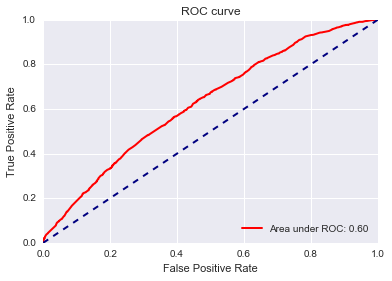

In [46]:
plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label='Area under ROC: {:.2f}'.format(auc))
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('ROC curve')
plt.show()

In [47]:
# Present features importance by their corresponding coefficients in logistic regression
coef = list(zip(df.drop('active', axis=1).columns, gb.feature_importances_))
fet = pd.DataFrame(coef, columns=['feature', 'coefficient'])
fet.sort_values('coefficient', ascending=False)

,feature,coefficient
2,org_id,0.479224
3,invited_by_user_id,0.196194
6,creation_source_PERSONAL_PROJECTS,0.191961
5,creation_source_ORG_INVITE,0.054550
4,creation_source_GUEST_INVITE,0.025831
8,creation_source_SIGNUP_GOOGLE_AUTH,0.019760
0,opted_in_to_mailing_list,0.017685
1,enabled_for_marketing_drip,0.013877
7,creation_source_SIGNUP,0.000917


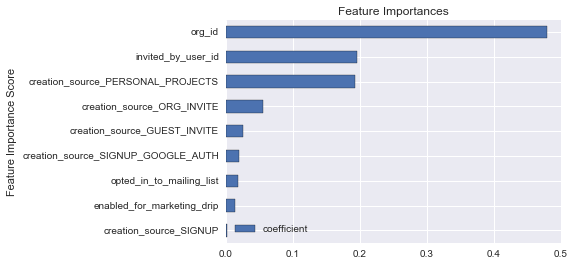

In [48]:
fet.set_index('feature').sort_values('coefficient').plot(kind='barh', title='Feature Importances')
plt.ylabel('Feature Importance Score')